In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import ensemble_model.preprocesser as preprocesser 
import ensemble_model.MoE_model as moe 
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

In [2]:
# df['command'] = df['diff'].apply(lambda x : extract_lines(find_longest_list([y.changes for y in whatthepatch.parse_patch(x)])))
# extracted_cols = df['diff'].str.extract(r'^diff --git (?P<source>[^\t\n]+) (?P<target>[^\t\n]+)')
# whatthepatch.apply_diff(diff, lao)

In [3]:
# len(df_dataset)

In [4]:
# df_dataset[0]

In [5]:
# Load BERT and CodeBERT models and tokenizers
bert_model = BertModel.from_pretrained('./models/bert-base-cased')
bert_tokenizer = BertTokenizer.from_pretrained('./models/bert-base-cased')

codebert_model = RobertaModel.from_pretrained('./models/codebert-base')
codebert_tokenizer = RobertaTokenizer.from_pretrained('./models/codebert-base')

/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
# train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
# test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
val = pd.read_csv('./datasets/val.csv')

train.reset_index(inplace=True)
test.reset_index(inplace=True)
val.reset_index(inplace=True)

/root/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10 Loss: 0.4304: 100%|██████████| 222/222 [10:05<00:00,  1.17batch/s]

=============================train========================
=============================eval========================


Epoch 1/10 Loss: 0.4304: 100%|██████████| 222/222 [11:53<00:00,  3.22s/batch]

Validation Accuracy: 0.8681608437705999
Precision: 0.8702536643435015
Recall: 0.8681608437705999
F1-Score: 0.8688107228505451
Epoch 1/10, Validation Accuracy: 0.8681608437705999
当前best acc 0.8681608437705999


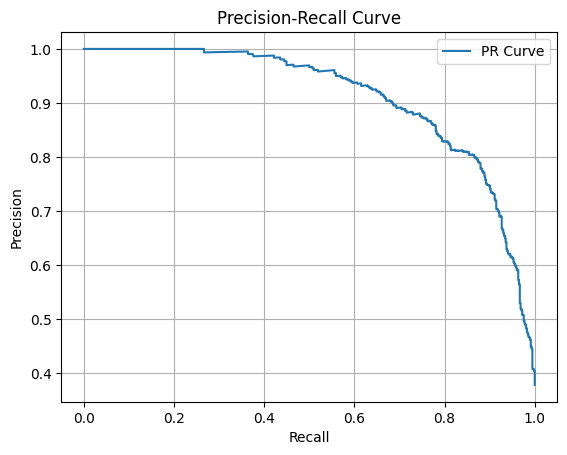

embedding来啦 (1536,)


Epoch 2/10 Loss: 0.2289: 100%|██████████| 222/222 [09:03<00:00,  1.05s/batch]

=============================train========================
=============================eval========================


Epoch 2/10 Loss: 0.2289: 100%|██████████| 222/222 [10:44<00:00,  2.91s/batch]

Validation Accuracy: 0.8885959129861569
Precision: 0.8884234003753035
Recall: 0.8885959129861569
F1-Score: 0.8884995289805476
Epoch 2/10, Validation Accuracy: 0.8885959129861569
当前best acc 0.8885959129861569


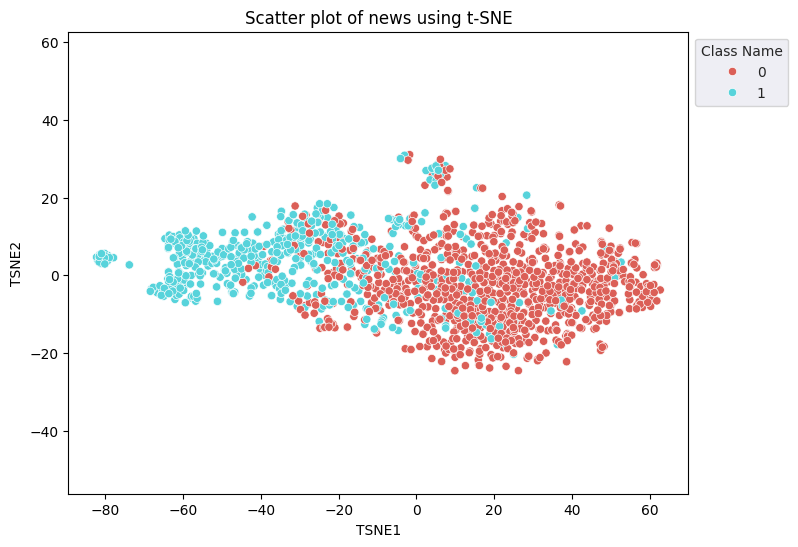

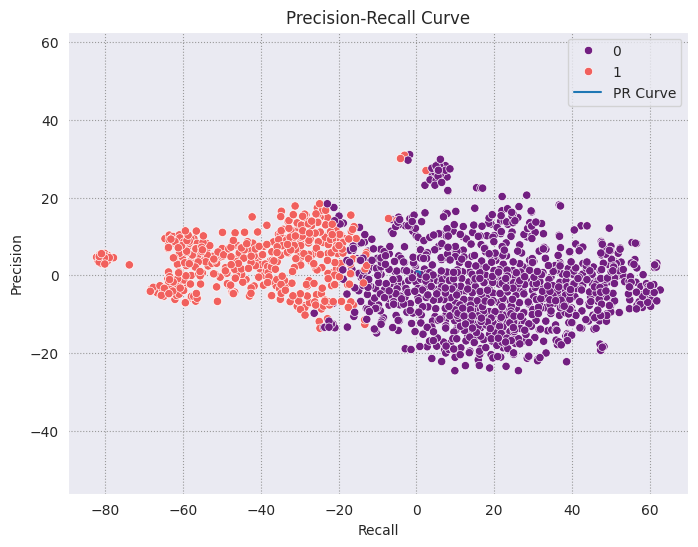

embedding来啦 (1536,)


Epoch 3/10 Loss: 0.1336: 100%|██████████| 222/222 [08:46<00:00,  1.06batch/s]

=============================train========================
=============================eval========================


Epoch 3/10 Loss: 0.1336: 100%|██████████| 222/222 [10:24<00:00,  2.81s/batch]

Validation Accuracy: 0.8872775214238628
Precision: 0.8966418363443535
Recall: 0.8872775214238628
F1-Score: 0.8834568949977655
Epoch 3/10, Validation Accuracy: 0.8872775214238628
比best acc差记一次 0


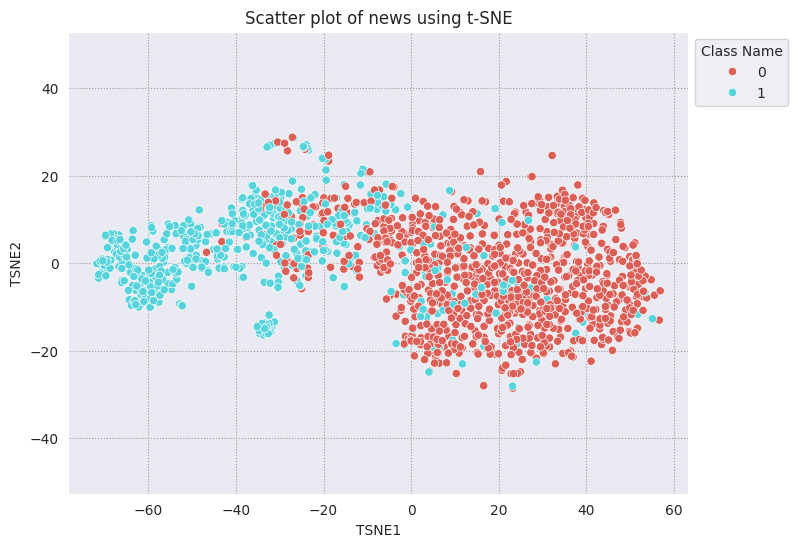

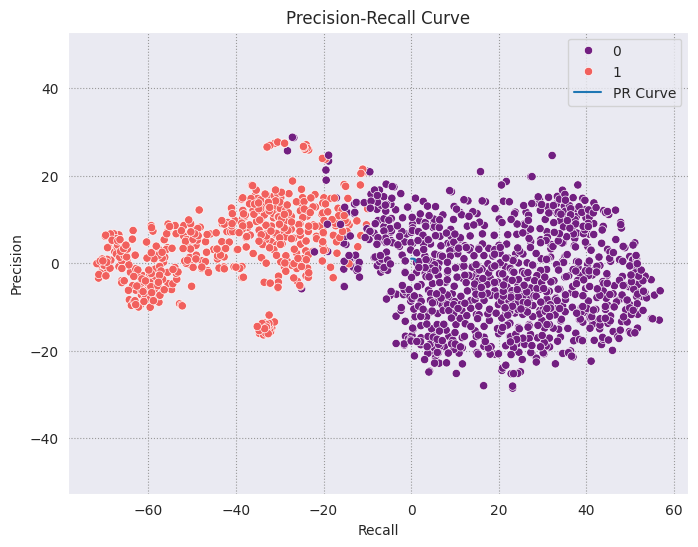

embedding来啦 (1536,)


Epoch 4/10:  19%|█▉        | 43/222 [00:57<01:46,  1.68batch/s]

In [ ]:


# Create Datasets and DataLoaders
train_dataset = preprocesser.SentencePairDataset(train, bert_tokenizer, codebert_tokenizer,message='message',command='diff',label='label')
val_dataset = preprocesser.SentencePairDataset(val, bert_tokenizer, codebert_tokenizer,message='message',command='diff',label='label')
test_dataset = preprocesser.SentencePairDataset(test, bert_tokenizer, codebert_tokenizer,message='message',command='diff',label='label')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# # Initialize the model
# model = em.CombinedModel(bert_model, codebert_model, bert_tokenizer, codebert_tokenizer)

# # Train the model
# model.trainer(train_loader, val_loader,num_epochs=10)
# for batch in train_loader:
#     print(batch)


base_model1 = moe.BaseModel(bert_model,bert_tokenizer)
base_model2 = moe.BaseModel(codebert_model,codebert_tokenizer)

# Create stacking model
moe_model = moe.MoEModel(base_model1, base_model2)
# Train the model
moe_model.trainer(train_loader, val_loader,num_epochs=10, patience=3)

In [ ]:
# import torch

In [ ]:
# test_dataset = preprocesser.SentencePairDataset(test_data, bert_tokenizer, codebert_tokenizer,message='commit_message',command='diff_code',label='category')
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [9]:
test_acc, test_labels, test_probabilities, test_embeddings, test_predictions = moe_model.evaluate(test_loader)

Validation Accuracy: 0.8998022412656559
Precision: 0.9025027512393421
Recall: 0.8998022412656559
F1-Score: 0.9003810229459687


In [10]:
res = test.copy()

In [11]:
res['test_labels'] = test_labels
res['test_probabilities'] = test_probabilities
res['test_embeddings'] = test_embeddings
res['test_predictions'] = test_predictions

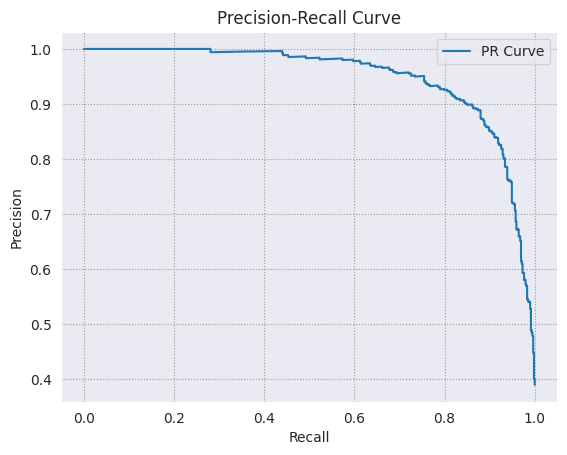

In [12]:
# PR curve
moe_model.plot_pr_curve(test_labels, test_probabilities)
# Plot t-SNE for the best model

embedding来啦 (1536,)


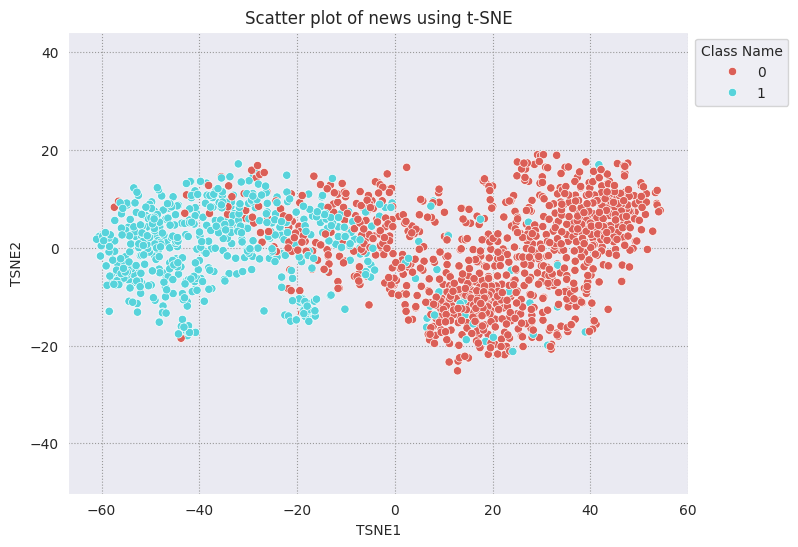

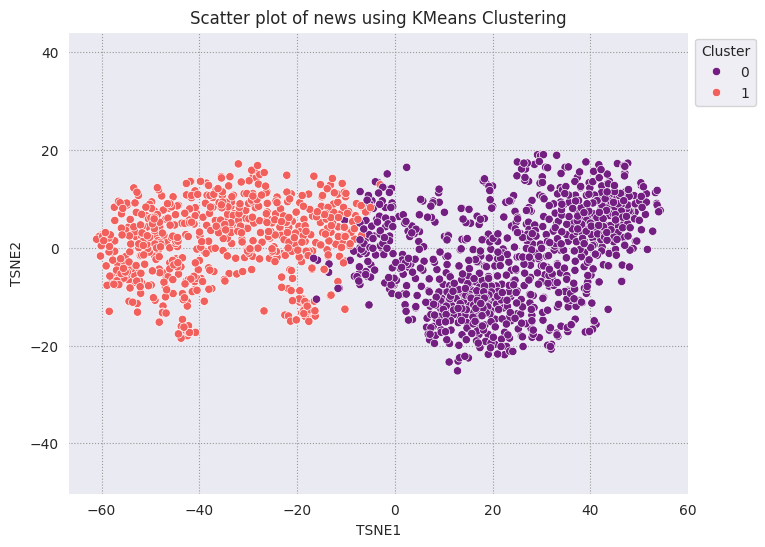

In [13]:
# cluster to show the quality of embeddings
moe_model.plot_tsne(test_embeddings, test_labels)

In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix on Dataset I', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    plt.tight_layout()

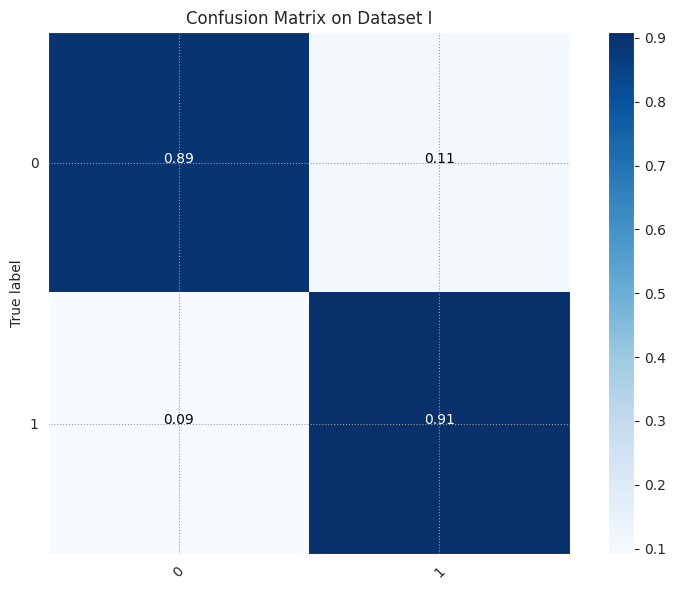

In [16]:
cm = confusion_matrix(test_labels, test_predictions)

# Call the function to plot the confusion matrix
class_names = test['label'].unique()  # Replace with your class names
plot_confusion_matrix(cm, classes=class_names, normalize=True)  # Set normalize=False if you want counts instead of percentages
plt.savefig('moe model Confusion Matrix on Dataset I')

In [17]:
res.to_csv('res_moe_model_dataset_I.csv')

In [18]:
res_mis = test.dropna().copy()

In [19]:
test

,index,Unnamed: 0,label,message,diff
0,0,7762,0,Merge pull request #90 from hlef/master\n\nFix...,diff --git a/NEWS b/NEWS\nindex 812291ff..ea51...
1,1,7566,0,[ZEPPELIN-5190] flink-1.12-shims CollectStream...,diff --git a/flink/flink1.12-shims/src/main/ja...
2,2,7606,0,Remode UNIXODBC_SOURCE from unixodbc_conf.h,diff --git a/ChangeLog b/ChangeLog\nindex 16e3...
3,3,5272,0,Explicitly enable utf8 on jdbc connection url\...,diff --git a/templates/gerrit.config.erb b/tem...
4,4,7537,1,Merge pull request #18 from g-sato/fix_securit...,diff --git a/index.php b/index.php\nindex 3246...
...,...,...,...,...,...
1512,1512,6112,0,updates: Use PF4 progress bar instead of custo...,diff --git a/pkg/apps/utils.jsx b/pkg/apps/uti...
1513,1513,274,1,error log and xss and some minor improvents\n\...,diff --git a/admin/class-user-login-history-us...
1514,1514,480,1,avformat/rmdec: Fix DoS due to lack of eof che...,diff --git a/libavformat/rmdec.c b/libavformat...
1515,1515,5688,1,Add side-channel countermeasures to DSA.\n\nTh...,diff --git a/lib/Crypto/PublicKey/DSA.py b/lib...


In [30]:
# 设置数据缺失的情况
# 设置随机种子以便结果可重复
import numpy as np
def data_missing(df):
    
    np.random.seed(42)
    
    # 定义缺失值的比例
    missing_rate = 0.2
    
    # 计算每列需要创建缺失值的数量
    num_missing = int(missing_rate * len(df))
    
    # 随机选择行进行缺失
    for col in ['message', 'diff']:
        missing_indices = np.random.choice(df.index, num_missing, replace=False)
        
        # 选择每个单元格的部分字符来替换，而不是全部替换成NaN
        for idx in missing_indices:
            if np.random.rand() > 0.5:
                # 保留前半部分
                try:
                    # print(df.loc[idx, col][:len(df.loc[idx, col])//2] + '...')
                    df.loc[idx, col] = df.loc[idx, col][:len(df.loc[idx, col])//2] + '...'
                except:
                    continue
            else:
                # 保留后半部分
                try:
                    # print('...' + df.loc[idx, col][len(df.loc[idx, col])//2:])
                    df.loc[idx, col] = '...' + df.loc[idx, col][len(df.loc[idx, col])//2:]
                except:
                    continue
    
    return df
test_data_miss = data_missing(test.dropna().copy())

In [31]:
# test.dropna(inplace=True)

In [32]:
test_data_miss

,index,Unnamed: 0,label,message,diff
0,0,7762,0,Merge pull request #90 from hlef/master\n\nFix...,diff --git a/NEWS b/NEWS\nindex 812291ff..ea51...
1,1,7566,0,[ZEPPELIN-5190] flink-1.12-shims CollectStream...,diff --git a/flink/flink1.12-shims/src/main/ja...
2,2,7606,0,Remode UNIXODBC_SOURCE from unixodbc_conf.h,"...ne PLATFORM64 /**/\n@@ -468,10 +468,9 @@\n ..."
3,3,5272,0,Explicitly enable utf8 on jdbc connection url\...,diff --git a/templates/gerrit.config.erb b/tem...
4,4,7537,1,Merge pull request #18 from g-sato/fix_securit...,"...php echo htmlspecialchars($siteroot, ENT_QU..."
...,...,...,...,...,...
1512,1512,6112,0,updates: Use PF4 progress...,diff --git a/pkg/apps/utils.jsx b/pkg/apps/uti...
1513,1513,274,1,error log and xss and some minor improvents\n\...,diff --git a/admin/class-user-login-history-us...
1514,1514,480,1,avformat/rmdec: Fix DoS due to lack of eof che...,diff --git a/libavformat/rmdec.c b/libavformat...
1515,1515,5688,1,Add side-channel countermeasures to DSA.\n\nTh...,diff --git a/lib/Crypto/PublicKey/DSA.py b/lib...


In [33]:
test_data_miss['message']

0       Merge pull request #90 from hlef/master\n\nFix...
1       [ZEPPELIN-5190] flink-1.12-shims CollectStream...
2             Remode UNIXODBC_SOURCE from unixodbc_conf.h
3       Explicitly enable utf8 on jdbc connection url\...
4       Merge pull request #18 from g-sato/fix_securit...
                              ...                        
1512                         updates: Use PF4 progress...
1513    error log and xss and some minor improvents\n\...
1514    avformat/rmdec: Fix DoS due to lack of eof che...
1515    Add side-channel countermeasures to DSA.\n\nTh...
1516                      Fix VS attribute size handling.
Name: message, Length: 1509, dtype: object

In [34]:
test_data_miss[test_data_miss['message'].str.contains('...')]

,index,Unnamed: 0,label,message,diff
0,0,7762,0,Merge pull request #90 from hlef/master\n\nFix...,diff --git a/NEWS b/NEWS\nindex 812291ff..ea51...
1,1,7566,0,[ZEPPELIN-5190] flink-1.12-shims CollectStream...,diff --git a/flink/flink1.12-shims/src/main/ja...
2,2,7606,0,Remode UNIXODBC_SOURCE from unixodbc_conf.h,"...ne PLATFORM64 /**/\n@@ -468,10 +468,9 @@\n ..."
3,3,5272,0,Explicitly enable utf8 on jdbc connection url\...,diff --git a/templates/gerrit.config.erb b/tem...
4,4,7537,1,Merge pull request #18 from g-sato/fix_securit...,"...php echo htmlspecialchars($siteroot, ENT_QU..."
...,...,...,...,...,...
1512,1512,6112,0,updates: Use PF4 progress...,diff --git a/pkg/apps/utils.jsx b/pkg/apps/uti...
1513,1513,274,1,error log and xss and some minor improvents\n\...,diff --git a/admin/class-user-login-history-us...
1514,1514,480,1,avformat/rmdec: Fix DoS due to lack of eof che...,diff --git a/libavformat/rmdec.c b/libavformat...
1515,1515,5688,1,Add side-channel countermeasures to DSA.\n\nTh...,diff --git a/lib/Crypto/PublicKey/DSA.py b/lib...


In [38]:
# test_data_miss.dropna(inplace=True)

In [39]:
test_data_miss.reset_index(inplace=True)
test_miss_dataset = preprocesser.SentencePairDataset(test_data_miss, bert_tokenizer, codebert_tokenizer,message='message',command='diff',label='label')
test_miss_loader = DataLoader(test_miss_dataset, batch_size=32, shuffle=False)
test_miss_loader

In [40]:
test_miss_acc, test_miss_labels, test_miss_probabilities, test_miss_embeddings, test_miss_predictions = moe_model.evaluate(test_miss_loader)

Validation Accuracy: 0.8721007289595759
Precision: 0.8727198711516033
Recall: 0.8721007289595759
F1-Score: 0.872343718865388


In [41]:
res_mis['test_miss_labels'] = test_miss_labels
res_mis['test_miss_probabilities'] = test_miss_probabilities
res_mis['test_miss_embeddings'] = test_miss_embeddings
res_mis['test_miss_predictions'] = test_miss_predictions

In [42]:
res_mis.to_csv('res_moe_model_dataset_I_data_missing.csv')

In [ ]:
1